In [1]:
!pip install -Uqq duckduckgo_search

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [29]:
elements = ['cell confocal','neuron confocal']
urls = search_images(elements[0], max_images=10)
example = urls[8]
example

'https://www.uniklinik-freiburg.de/fileadmin/mediapool/07_kliniken/med_innere1/bilder/core_facility/microscopy/Image_8_Airyscan_Processing_kidney.png'

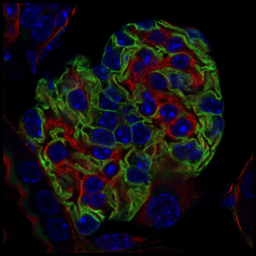

In [30]:
from fastdownload import download_url
dest = 'cell.jpg'
download_url(example, dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

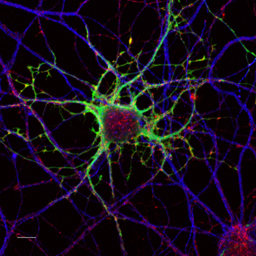

In [32]:
download_url(search_images(elements[1], max_images=1)[0], 'neuron.jpg', show_progress=False)
Image.open('neuron.jpg').to_thumb(256,256)

In [34]:
searches = 'cell confocal','neuron confocal'
path = Path('neuron_or_cell')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server

    resize_images(path/o, max_size=400, dest=path/o)
     

In [35]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


6

In [37]:
# blocks = (Inputs , Outputs ) -> (ImageBlock, CategoryBlock) mean input image output category
# get_items = Method , how to get image data get_image_files return all images files in the path
# splitter = method to split training an validation
# get_y = the function to use to get y, here parent_label return the label of parent folder
# item_tfms = how to preprocess items before running

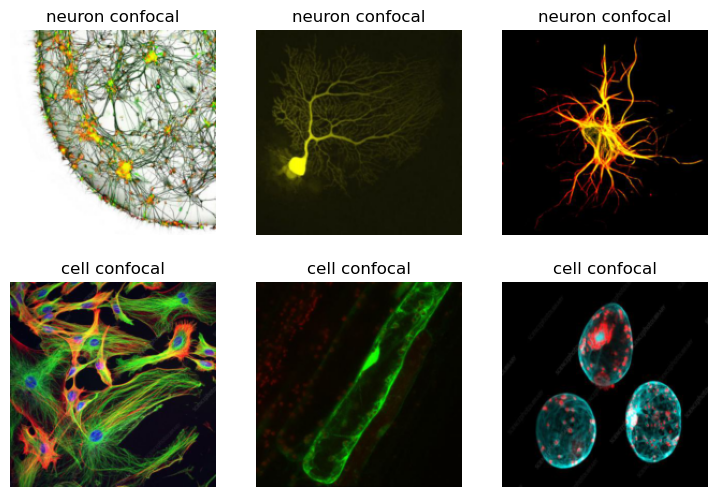

In [38]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [40]:

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,1.410229,2.749212,0.461538,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.145658,1.793469,0.410256,00:02
1,0.977552,1.214495,0.282051,00:02
2,0.840907,0.851882,0.282051,00:02
3,0.757756,0.699027,0.256410,00:02
4,0.643306,0.647988,0.179487,00:02
5,0.557150,0.765377,0.153846,00:02
6,0.497536,0.910411,0.153846,00:02
7,0.469707,1.033329,0.128205,00:02
8,0.426427,1.057096,0.128205,00:02
9,0.394753,1.021423,0.128205,00:02


In [45]:
is_cell,p,probs = learn.predict(PILImage.create('cell.jpg'))
print(f"This is a: {is_cell}.")
print(f"Probability it's a cell: {probs[0]:.4f}")
print(f"Probability it's a neuros: {probs[1]:.4f}")

This is a: cell confocal.
Probability it's a cell: 0.9957
Probability it's a neuros: 0.0043
